In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import uniform
from scipy.stats import randint
# insert other models you want to use here
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
# replace filepath here
data = pd.read_csv('after_feature_selection_forward_10.csv', parse_dates=['Date'])
data.head()

,total_Amount_card_description_7,total_Amount_card_description_3,max_Amount_card_state_14,total_Amount_Cardnum_3,total_Amount_card_description_1,total_Amount_Cardnum_0,total_Amount_card_description_0,total_Amount_Cardnum_14,max_Amount_card_state_30,max_Amount_Cardnum_3,Date,Fraud,Amount
0,293.22,293.22,3.67,438.57,293.22,438.57,293.22,438.57,3.67,3.67,2010-01-01,0,3.62
1,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,2010-01-01,0,31.42
2,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,2010-01-01,0,178.49
3,93.20,93.20,3.80,182.84,93.20,182.84,93.20,182.84,3.80,3.80,2010-01-01,0,3.62
4,293.22,293.22,3.67,438.57,293.22,438.57,293.22,438.57,3.67,3.67,2010-01-01,0,3.62


In [3]:
train_test = data[(data.Date >= '2010-01-15') & (data.Date <= '2010-10-31')].drop(columns=['Date'])
OOT = data[data.Date > '2010-10-31'].drop(columns=['Date'])

In [4]:
X = train_test.drop(columns=['Fraud', 'Amount'])
y = train_test['Fraud']
X_OOT = OOT.drop(columns=['Fraud', 'Amount'])
y_OOT = OOT['Fraud']

In [5]:
def get_fdr(model, X, y):
    y_pred = model.predict_proba(X)[:, 1]
    temp = pd.DataFrame({'y': y, 'y_pred': y_pred})
    actual_pos = y.sum()
    temp = temp.sort_values('y_pred', ascending=False)
    target_num = int(temp.shape[0] * 0.03)
    temp = temp.iloc[:target_num, :]
    detect_pos = temp['y'].sum()
    fdr = detect_pos / actual_pos
    return fdr

### Modeling

In [6]:
#Modified code: this will only train your model 1 time
# Whether you want to resample or not
smote_flag = True


model = MLPClassifier(random_state=1,max_iter=400,hidden_layer_sizes=(20,) ,solver='adam',activation='relu')

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_OOT_scaled = pd.DataFrame(scaler.transform(X_OOT), columns=X_OOT.columns)

#Capped 6
drop_index = ((X_train_scaled >= 6) | (X_train_scaled <= -6)).sum(axis=1)
drop_index = drop_index[drop_index >= 1].index.to_list()
X_train_scaled = X_train_scaled.drop(index=drop_index)
y_train = pd.DataFrame(y_train).iloc[X_train_scaled.index, :]['Fraud']

if smote_flag:
    y_neg_cnt = (y_train == 0).sum()
    smote = SMOTE(sampling_strategy={0: y_neg_cnt, 1: int(y_neg_cnt/10)})
    X_train_smo, y_train_smo = smote.fit_sample(X_train_scaled, y_train)
    model.fit(X_train_smo, y_train_smo)
else:
    model.fit(X_train_scaled, y_train)


# graph cost saving

In [7]:
y_oot_pred_prob=model.predict_proba(X_OOT_scaled)[:, 1]

In [8]:
y_oot_pred=model.predict(X_OOT_scaled)

In [9]:
final_oot=pd.DataFrame({'y': y_OOT,'y_oot_pred': y_oot_pred, 'y_pred_proba': y_oot_pred_prob}).sort_values('y_pred_proba',ascending=False)

In [10]:
final_oot=final_oot.reset_index().drop(columns='index')

In [11]:
final_oot['rank']=final_oot.index+1

In [12]:
final_oot['percent_population']=100*final_oot['rank']/len(final_oot)

In [13]:
Lost_Sales=[]
Fraud_Savings=[]
cur_saving=0
cur_LS=0
for i in range(len(final_oot)):
    if final_oot['y'][i]==1:
        cur_saving+=2000
    cur_LS+=50
    Fraud_Savings.append(cur_saving)
    Lost_Sales.append(cur_LS)

In [14]:
final_oot['Fraud_Savings']=Fraud_Savings
final_oot['Lost_Sales']=Lost_Sales

In [15]:
final_oot['Overall_Savings']=final_oot['Fraud_Savings']-final_oot['Lost_Sales']

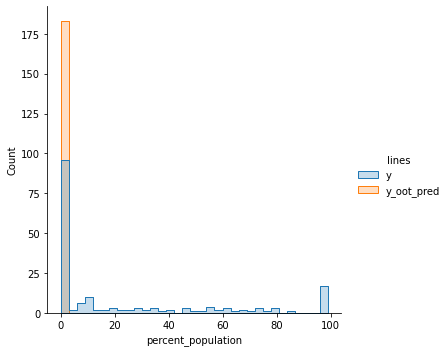

In [16]:
#just for your reference
tem=pd.melt(final_oot.loc[:,['y','y_oot_pred','percent_population']],id_vars='percent_population'\
        ,var_name='lines',value_name='amount')
sns.displot(tem.loc[tem['amount']==1], x="percent_population", hue="lines", element="step",bins=33)

In [17]:
graph_df=pd.melt(final_oot.drop(columns=['y','y_oot_pred','y_pred_proba','rank']),id_vars='percent_population'\
        ,var_name='lines',value_name='amount')

In [18]:
final_oot.head()

,y,y_oot_pred,y_pred_proba,rank,percent_population,Fraud_Savings,Lost_Sales,Overall_Savings
0,0,1,1.0,1,0.008047,0,50,-50
1,0,1,1.0,2,0.016094,0,100,-100
2,1,1,1.0,3,0.024141,2000,150,1850
3,1,1,1.0,4,0.032188,4000,200,3800
4,0,1,1.0,5,0.040235,4000,250,3750


In [21]:
final_oot.loc[final_oot['Overall_Savings']<final_oot['Overall_Savings'].max()]['Overall_Savings'].values[0]*l/y_max

-0.00015562302610499978

In [31]:
final_oot.loc[final_oot['percent_population']<2.49].tail(1)

,y,y_oot_pred,y_pred_proba,rank,percent_population,Fraud_Savings,Lost_Sales,Overall_Savings
308,1,0,0.287912,309,2.486521,192000,15450,176550


In [29]:
final_oot.Overall_Savings.max()

176550

In [22]:
final_oot.loc[final_oot['percent_population']<3].tail(1)['Overall_Savings'].values[0]

173400

In [ ]:
#graph_df.loc[(graph_df['lines']=='Overall_Savings') & (graph_df['percent_population']<5)]

Text(0.5, 0, 'OOT Population % bins')

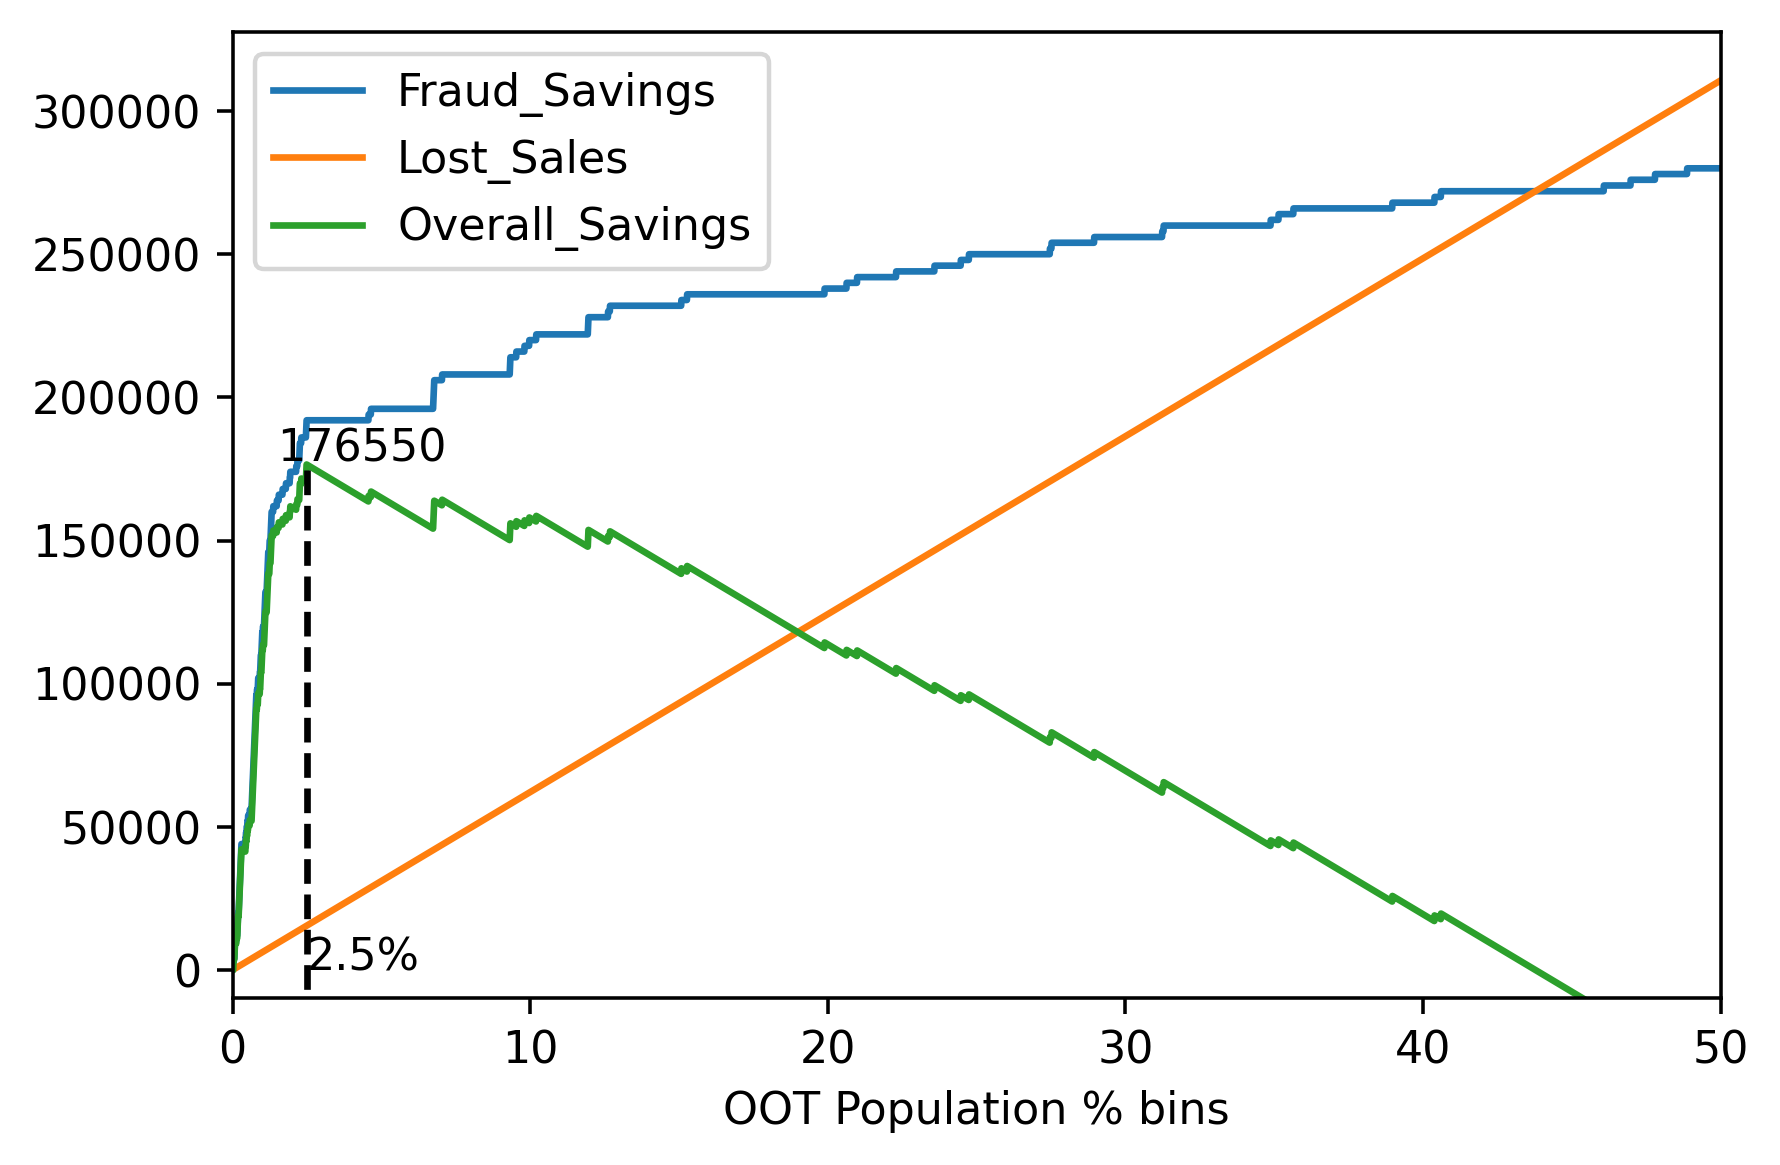

In [33]:
plt.figure(dpi=320)
#plt.figure(figsize=(12,12))
sns.lineplot(data=graph_df.loc[graph_df.percent_population<50], x="percent_population", y="amount", hue="lines")

axes = plt.gca()
y_min, y_max = axes.get_ylim()
plt.ylim([-y_max*0.03,y_max])
plt.xlim([0,50])
#customize the value x yourself by looking at the graph, x is the cutoff in percent%
x=2.5
#you can also change l to adjust the length of the black dotted line
l=1.02
plt.text(x-1,final_oot.loc[final_oot['percent_population']<2.49].tail(1)['Overall_Savings'].values[0]+1000,final_oot.loc[final_oot['percent_population']<2.49].tail(1)['Overall_Savings'].values[0])
ymax=final_oot.loc[final_oot['Overall_Savings']==final_oot['Overall_Savings'].max()]['Overall_Savings'].values[0]*l/y_max

plt.axvline(x=x,ymax=ymax,ymin=y_min,color="black",linestyle='dashed')

plt.text(x,0,str(x)+'%')
plt.legend(title='')
plt.ylabel('')
plt.xlabel('OOT Population % bins')
